#**Giới thiệu DAIBL**

Đề tài: **Xây dựng mô hình máy học phân loại bình luận theo cảm xúc.**

Phân loại: **Tích cực (POS)**, **Tiêu cực (NEG)**, **Trung lập (NEU)**.

Phương pháp: **Support Vector Machines (SVM).**

Dữ liệu: **[Vietnamese Sentiment Analysis (Kaggle)](https://www.kaggle.com/datasets/linhlpv/vietnamese-sentiment-analyst).**

#**Cài đặt thư viện**

In [14]:
# Cài đặt thư viện nếu có

#**Import thư viện**

In [1]:
# core
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

# NLP
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report

# save models
import pickle

#**Đọc dữ liệu**

In [2]:
df = pd.read_csv('data.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31460 entries, 0 to 31459
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  31460 non-null  object
 1   label    31460 non-null  object
dtypes: object(2)
memory usage: 491.7+ KB


,content,label
0,Áo bao đẹp ạ!!,POS
1,Tuyệt vời !,POS
2,2day ao khong giong trong.,NEG
3,"Mùi thơm,bôi lên da mềm da.",POS
4,"Vải đẹp, dày dặn.",POS


#**Tiền xử lý dữ liệu**

##Loại bỏ giá trị thiếu

In [3]:
df = df.dropna()
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31460 entries, 0 to 31459
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  31460 non-null  object
 1   label    31460 non-null  object
dtypes: object(2)
memory usage: 491.7+ KB


,content,label
0,Áo bao đẹp ạ!!,POS
1,Tuyệt vời !,POS
2,2day ao khong giong trong.,NEG
3,"Mùi thơm,bôi lên da mềm da.",POS
4,"Vải đẹp, dày dặn.",POS


##Chuyển đổi văn bản cột **content** thành chữ thường

In [4]:
df['content'] = df['content'].str.lower()
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31460 entries, 0 to 31459
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  31460 non-null  object
 1   label    31460 non-null  object
dtypes: object(2)
memory usage: 491.7+ KB


,content,label
0,áo bao đẹp ạ!!,POS
1,tuyệt vời !,POS
2,2day ao khong giong trong.,NEG
3,"mùi thơm,bôi lên da mềm da.",POS
4,"vải đẹp, dày dặn.",POS


##Làm sạch văn bản trong cột **content**

In [5]:
clear_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"
                u"\U0001F300-\U0001F5FF"
                u"\U0001F680-\U0001F6FF"
                u"\U0001F1E0-\U0001F1FF"
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE)

def clean_text(text):
  text = re.sub(clear_pattern, " ", text)
  text = re.sub(r'([a-z]+?)\1+',r'\1', text)
  text = re.sub(r"(\w)\s*([" + string.punctuation + "])\s*(\w)", r"\1 \2 \3", text)
  text = re.sub(r"(\w)\s*([" + string.punctuation + "])", r"\1 \2", text)
  text = re.sub(f"([{string.punctuation}])([{string.punctuation}])+",r"\1", text)
  text = text.strip()
  while text.endswith(tuple(string.punctuation+string.whitespace)):
      text = text[:-1]
  while text.startswith(tuple(string.punctuation+string.whitespace)):
      text = text[1:]
  text = re.sub(r"\s+", " ", text)
  return text

df['content'] = df['content'].map(lambda text: clean_text(text))
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31460 entries, 0 to 31459
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  31460 non-null  object
 1   label    31460 non-null  object
dtypes: object(2)
memory usage: 491.7+ KB


,content,label
0,áo bao đẹp ạ,POS
1,tuyệt vời,POS
2,2day ao khong giong trong,NEG
3,"mùi thơm , bôi lên da mềm da",POS
4,"vải đẹp , dày dặn",POS


##Xóa ký tự số cột **content**

In [6]:
def remove_digits(text):
  return ''.join([char for char in str(text) if not char.isdigit()])

df['content'] = df['content'].apply(remove_digits)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31460 entries, 0 to 31459
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  31460 non-null  object
 1   label    31460 non-null  object
dtypes: object(2)
memory usage: 491.7+ KB


,content,label
0,áo bao đẹp ạ,POS
1,tuyệt vời,POS
2,day ao khong giong trong,NEG
3,"mùi thơm , bôi lên da mềm da",POS
4,"vải đẹp , dày dặn",POS


##Loại bỏ ký tự đặc biệt cột **content**

In [7]:
def remove_special_characters(text):
  text = re.sub(r'[^a-zA-Z0-9áàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợúùủũụưứừửữựíìỉĩịýỳỷỹỵđĐ ]', '', text)
  return text

df['content'] = df['content'].apply(remove_special_characters)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31460 entries, 0 to 31459
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  31460 non-null  object
 1   label    31460 non-null  object
dtypes: object(2)
memory usage: 491.7+ KB


,content,label
0,áo bao đẹp ạ,POS
1,tuyệt vời,POS
2,day ao khong giong trong,NEG
3,mùi thơm bôi lên da mềm da,POS
4,vải đẹp dày dặn,POS


##Loại bỏ dấu câu cột **content**

In [8]:
def remove_vietnamese_accent(text):
  text = re.sub(r'[áàảãạăắằẳẵặâấầẩẫậ]', 'a', text)
  text = re.sub(r'[éèẻẽẹêếềểễệ]', 'e', text)
  text = re.sub(r'[óòỏõọôốồổỗộơớờởỡợ]', 'o', text)
  text = re.sub(r'[íìỉĩị]', 'i', text)
  text = re.sub(r'[úùủũụưứừửữự]', 'u', text)
  text = re.sub(r'[ýỳỷỹỵ]', 'y', text)
  text = re.sub(r'[đ]', 'd', text)
  return text

df['content'] = df['content'].apply(remove_vietnamese_accent)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31460 entries, 0 to 31459
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  31460 non-null  object
 1   label    31460 non-null  object
dtypes: object(2)
memory usage: 491.7+ KB


,content,label
0,ao bao dep a,POS
1,tuyet voi,POS
2,day ao khong giong trong,NEG
3,mui thom boi len da mem da,POS
4,vai dep day dan,POS


#**Mã hóa dữ liệu**

##Mã hóa **label** thành dạng số

In [9]:
label_mapping = {'POS': 1, 'NEU': 0, 'NEG': -1}
df['label'] = df['label'].map(label_mapping)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31460 entries, 0 to 31459
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  31460 non-null  object
 1   label    31460 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 491.7+ KB


,content,label
0,ao bao dep a,1
1,tuyet voi,1
2,day ao khong giong trong,-1
3,mui thom boi len da mem da,1
4,vai dep day dan,1


##Mã hóa **content** thành dạng **TF-IDF**

In [10]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['content'])
y = df['label']

# with open('vectorizer.pkl', 'wb') as file:
#   pickle.dump(vectorizer, file)

#**Chia dữ liệu huấn luyện**

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
  X,
  y,
  test_size=0.2,
  random_state=42
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(25168, 2435) (6292, 2435) (25168,) (6292,)


#**Huấn luyện mô hình**

In [12]:
model = SVC(C=3, kernel='rbf')
model.fit(X_train, y_train)

# with open('model.pkl', 'wb') as file:
#   pickle.dump(model, file)

SVC(C=3)

#**Đánh giá mô hình**

Độ chính xác: 77.73%


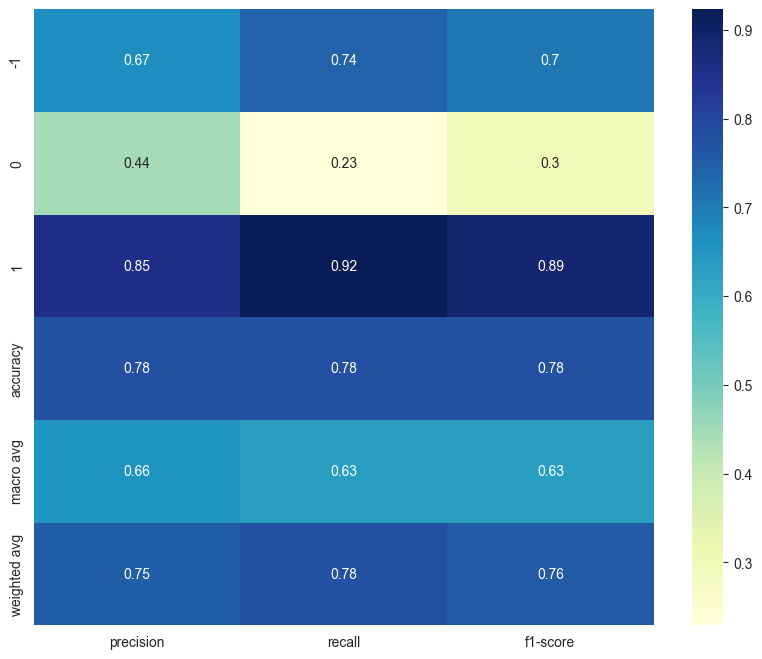

In [13]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Độ chính xác: {round(accuracy * 100, 2)}%\n")

report = classification_report(y_test, y_pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df = df.drop(['support'], axis=1)

plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, cmap='YlGnBu')
plt.show()

#**Tinh chỉnh mô hình**

In [14]:
param_grid = {
  'C': [1, 2, 3, 4, 5],
  'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
  'gamma': ['scale', 'auto']
}
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best parameters: ", grid_search.best_params_)

KeyboardInterrupt: 

#**Huấn luyện mô hình sau tinh chỉnh**

In [14]:
model = SVC(C=1, gamma='scale', kernel='rbf')
model.fit(X_train, y_train)

SVC(C=1)

#**Đánh giá mô hình sau tinh chỉnh**

Độ chính xác: 78.19%


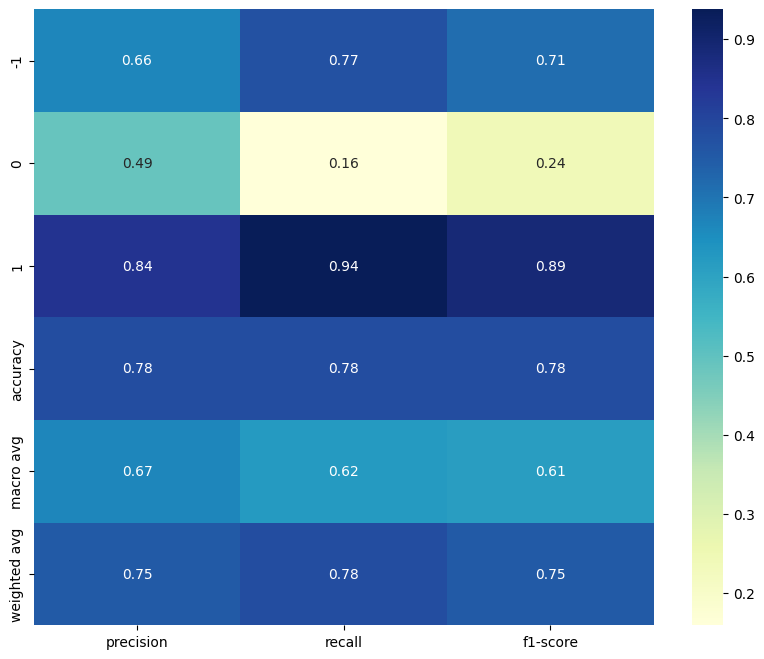

In [15]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Độ chính xác: {round(accuracy * 100, 2)}%\n")

report = classification_report(y_test, y_pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df = df.drop(['support'], axis=1)

plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, cmap='YlGnBu')
plt.show()